## Data download

In [21]:
import os

if not os.path.exists('/./embeddings.zip'):
  data_set='kaggle competitions download -c quora-insincere-questions-classification'

  if not os.path.exists('/./kaggle.json'):
    from google.colab import files
    files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !{data_set}
    !unzip -q quora-insincere-questions-classification


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
quora-insincere-questions-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
replace embeddings.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [29]:
class CONFIGURATION:
  sample_size=100000
  max_iter = 1000
config=CONFIGURATION()

## Exploring the data

In [4]:
train = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
sincere_df = train[train.target==0]
insincere_df=train[train.target==1]

In [ ]:
sincere_df.question_text.values[10:20]

In [ ]:
insincere_df.question_text.values[10:20]

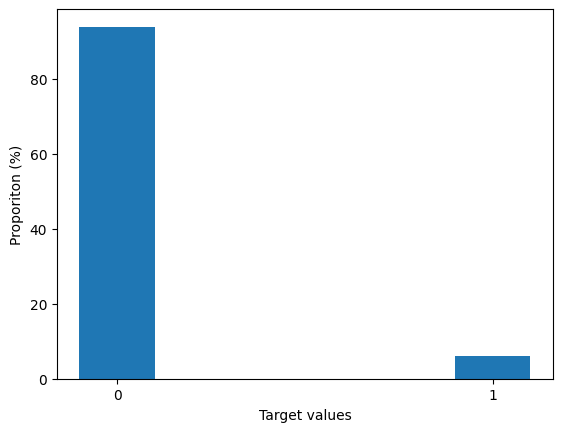

In [6]:
proportion = 100*train.target.value_counts(normalize=True)
plt.bar(proportion.index, proportion.values,width=0.2)
plt.ylabel('Proporiton (%)')
plt.xlabel('Target values')
plt.xticks([0,1])
plt.show()

## Text preprocessing
1. Tokenization
2. Filtering Stopwords
3. Stemming

In [7]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### 1. Tokenization

In [8]:
q0=sincere_df['question_text'].values[0]
q1 = insincere_df['question_text'].values[0]

In [9]:
q0_tok = word_tokenize(q0)
q1_tok = word_tokenize(q1)

#### 2. Filtering Stopwords

In [10]:
english_stopwords = stopwords.words('english')
# function to filter out stop words
def filter_stopwords(tokens):
  return [word for word in tokens if word.lower() not in english_stopwords]

#### 3. Stemming

In [11]:
stemmer = SnowballStemmer(language='english')

def tokenize_with_stemming(text):
  return [stemmer.stem(word) for word in word_tokenize(text)]

## Bag of Words
CountVectorizer from sklearn.feature_extraction is used to implement BoW technique


In [12]:
# sampled dataframe
sample_df = train.sample(config.sample_size, random_state=34)
questions = list(sample_df.question_text.values)

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=True, tokenizer=tokenize_with_stemming,
                            stop_words=english_stopwords,
                             max_features=1000)
# Training the vectorizer on questions data
vectorizer.fit(questions)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


CountVectorizer(max_features=1000,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                tokenizer=<function tokenize_with_stemming at 0x77fc7b3e5120>)

In [20]:
test_df=pd.read_csv('test.csv')
test_questions = list(test_df.question_text.values)
inputs=vectorizer.transform(questions)
test_inputs = vectorizer.transform(test_questions)

## ML Model
Split the data into training and validation sets and train a logistic regression model

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(inputs,
                                    sample_df.target,
                                    test_size=0.3, random_state=43
                                    )

In [30]:
# logistic regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=config.max_iter, solver='sag')

# trianing the model
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='sag')

In [34]:
# Making prediciton
pred = model.predict(X_train)

In [38]:
(pred==y_train).value_counts(normalize=True)

target
True     0.9486
False    0.0514
Name: proportion, dtype: float64

In [39]:
# Trai Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_train, pred)

0.9486